## TODO

- memory usage of processing sampling shuffle is *huge*
    - subset processing
    - using collate_fn during training
- using summary feature as input

In [63]:
import os
import h5py
import numpy as np
from memory_profiler import profile
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from tqdm import tqdm
from dataset.data_process import process_x_seqC_part
import torch
import time
from copy import deepcopy

In [ ]:
# check dataset generated for experiment set 0 with model L0
data_path = '../../data/dataset'
!ls $data_path
f1 = h5py.File(data_path + '/dataset_part_0.h5', 'r')
f2 = h5py.File(data_path + '/dataset_part_0_snn.h5', 'r')

In [ ]:
f1['data']['seqC'], f1['data']['theta'], f1['data']['probR']
f2['data']['seqC'], f2['data']['theta'], f2['data']['probR']

check if the two datasets are the same (using same seed on different machines)

In [ ]:
print('comparing snn and uzh generated datasets...')
issame_seqC = not np.sum(np.nan_to_num(f1['data']['seqC'][:], -1)!=np.nan_to_num(f2['data']['seqC'][:], -1))
issame_theta = not np.sum(np.nan_to_num(f1['data']['theta'][:], -1)!=np.nan_to_num(f2['data']['theta'][:], -1))
issame_probR = not np.sum(np.nan_to_num(f1['data']['probR'][:], -1)!=np.nan_to_num(f2['data']['probR'][:], -1))
print("seqC are the same") if issame_seqC else print("!seqC are different!")
print("theta are the same") if issame_theta else print("!theta are different!")
print("probR are the same") if issame_probR else print("!probR are different!")

In [ ]:
f1.close()
f2.close()

## merge datasets into one

In [ ]:
# list the files in the data directory using python
data_dir = '../../data/dataset'
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

data_paths = []
data_file_idxs = []
for data_file in files:
    data_path = f'{data_dir}/{data_file}'
    data_paths.append(data_path)
    # sort the data paths according to the file name
    data_paths.sort(key=lambda x: x.split('_part_')[-1].split('.')[0])
    data_file_idxs.append(int(data_path.split('_part_')[-1].split('.')[0]))

In [ ]:
# create a new h5 file to store the combined dataset
merged_data_path = f'{data_dir}/dataset_L0_exp_set_0.h5'

with h5py.File(merged_data_path, 'w') as merged_data_file:
    
    for data_path, data_file_idx in zip(*(data_paths, data_file_idxs)):
        print(f'adding {data_path} to {merged_data_path}')
        data_file = h5py.File(data_path, 'r')
        # copy the data group from the data file to the merged data file
        set_group = merged_data_file.create_group(f'set_{data_file_idx}')
        data_file.copy('data/seqC', set_group)
        data_file.copy('data/probR', set_group)
        data_file.copy('data/theta', set_group)
        data_file.close()
        merged_data_file.flush()

    print(f'\nmerged file has keys: {list(merged_data_file.keys())}')    
    print(f"\nin one set_0 it has keys: {list(merged_data_file['set_0'].keys())}")
    print(f"seqC has a shape of: {merged_data_file['set_0']['seqC'].shape}")
    print(f"theta has a shape of: {merged_data_file['set_0']['theta'].shape}")
    print(f"probR has a shape of: {merged_data_file['set_0']['probR'].shape}")

# merged_data_file.close()

## process the x with MEM check 

In [2]:
%load_ext memory_profiler

In [7]:
@profile(precision=4)
def load_dataset():    
    data_path = '../../data/dataset/dataset_L0_exp_set_0.h5'
    f = h5py.File(data_path, 'r')
    seqC = f['set_0']['seqC'][:]
    probR = f['set_0']['probR'][:]
    print(seqC.shape, probR.shape)
    seqC = seqC.reshape((seqC.shape[0]*seqC.shape[1]*seqC.shape[2], seqC.shape[3]))
    probR = probR.reshape((probR.shape[0]*probR.shape[1]*probR.shape[2], probR.shape[3]))
    print(seqC.shape, probR.shape)
    return seqC

In [8]:
%%mprun -f load_dataset

load_dataset()

ERROR: Could not find file /tmp/ipykernel_1584372/3769736698.py
(7, 3, 700, 15) (7, 3, 700, 5000, 1)
(14700, 15) (14700, 5000)



Filename: /home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/memory_profiler.py

Line #    Mem usage    Increment  Occurences   Line Contents
  1140    338.2 MiB    338.2 MiB           1               def wrapper(*args, **kwargs):
  1141    338.2 MiB      0.0 MiB           1                   prof = get_prof()
  1142    340.3 MiB      2.1 MiB           1                   val = prof(func)(*args, **kwargs)
  1143    340.3 MiB      0.0 MiB           1                   show_results_bound(prof)
  1144    340.3 MiB      0.0 MiB           1                   return val

In [ ]:
# check reshaped dataset
data_path = '../../data/dataset/dataset_L0_exp_set_0.h5'
f = h5py.File(data_path, 'r')
seqC = f['set_0']['seqC'][:]
probR = f['set_0']['probR'][:]
print(seqC.shape, probR.shape)
seqC_ = seqC.reshape((seqC.shape[0]*seqC.shape[1]*seqC.shape[2], seqC.shape[3]))
probR_ = probR.reshape((probR.shape[0]*probR.shape[1]*probR.shape[2], probR.shape[3]))
print(seqC_.shape, probR_.shape)

## build dataset and dataLoader

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
probR = [0.5, 0.3, 0.1, 0.1]

probR    = torch.tensor(probR).unsqueeze_(dim=0).repeat_interleave(10, dim=0) # (C, D*M*S, 1)
x_choice = torch.bernoulli(probR) # (C, D*M*S, 1)
print(x_choice.shape, probR.shape)
probR = torch.tensor(probR).expand(10, -1, -1)
x_choice = torch.bernoulli(probR) # (C, D*M*S, 1)
print(x_choice.shape, probR.shape)

torch.Size([10, 4]) torch.Size([10, 4])
torch.Size([10, 10, 4]) torch.Size([10, 10, 4])


/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from train.MyData import MyDataset

class MyDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, C, shuffle=True, pin_memory=False, num_workers=0):
        super().__init__(dataset, batch_size, shuffle=shuffle, collate_fn=self.collate_fn, pin_memory=pin_memory, num_workers=num_workers)
        self.C = C
        
    def collate_fn(self, batch):
        # Process the batch
        x_batches, theta_batches = [], []
        
        # x_batch     = torch.empty((self.C * len(batch), batch[0][0].shape[0], batch[0][0].shape[1]+batch[0][2].shape[1]))
        # theta_batch = torch.empty((self.C * len(batch), batch[0][1].shape[0]))
        # Create tensors for probR and x_seqC outside the loop
        x_seqC_tensor = torch.empty((self.C, batch[0][0].shape[0], batch[0][0].shape[1]))
        probR_tensor = torch.empty((self.C, batch[0][2].shape[0], 1))
        print(len(batch), x_seqC_tensor.shape, probR_tensor.shape)
        
        for i, (seqC, theta, probR) in enumerate(batch): # seqC: (D*M*S, 15), theta: (4,), probR: (D*M*S, 1)
            
            # probR    = torch.tensor(probR).unsqueeze_(dim=0).repeat_interleave(self.C, dim=0) # (C, D*M*S, 1)
            probR_tensor.copy_(torch.tensor(probR).unsqueeze_(dim=0).repeat_interleave(self.C, dim=0)) # (C, D*M*S, 1)
            x_choice = torch.bernoulli(probR_tensor) # (C, D*M*S, 1)
            
            # x_seqC   = torch.tensor(seqC).unsqueeze_(dim=0).repeat_interleave(self.C, dim=0) # (C, D*M*S, 15)
            # x = torch.cat([x_seqC, x_choice], dim=-1)
            x_seqC_tensor.copy_(torch.tensor(seqC).unsqueeze_(dim=0).repeat_interleave(self.C, dim=0)) # (C, D*M*S, 15)
            x = torch.cat([x_seqC_tensor, x_choice], dim=-1)
            
            theta = torch.tensor(theta).unsqueeze_(dim=0).repeat_interleave(self.C, dim=0) # (C, 4)
            
            x_batches.append(x)
            theta_batches.append(theta)
        
        # Concatenate the batched tensors
        x_batch = torch.cat(x_batches, dim=0)
        theta_batch = torch.cat(theta_batches, dim=0)
        
        # Shuffle x along the 2nd axis
        # for i in range(x_batch.shape[0]):
        #     indices = torch.randperm(x_batch.shape[1])
        #     x_batch[i] = x_batch[i][indices]
        x_batch = torch.stack([x_batch[i][torch.randperm(x_batch.shape[1])] for i in range(x_batch.shape[0])])
            
        # Shuffle the batched dataset
        indices     = torch.randperm(x_batch.shape[0])
        x_batch     = x_batch[indices]
        theta_batch = theta_batch[indices]
        
        return torch.tensor(x_batch, dtype=torch.float32), torch.tensor(theta_batch, dtype=torch.float32)    

In [5]:
%load_ext memory_profiler

data_path = "../../data/dataset/dataset_L0_exp_set_0.h5"
batch_size = 200
C = 100

# Create a my dataset using the data path
my_dataset = MyDataset(data_path)

# Create a my data loader using the dataset, batch size, and C
my_dataloader = MyDataLoader(my_dataset, batch_size, C, shuffle=False)

@profile
def load_my_dataset():    
    next(iter(my_dataloader))
    

In [15]:
len(my_dataset)

10000

In [21]:
torch.randperm(10)

tensor([1, 3, 8, 4, 5, 2, 9, 6, 0, 7])

In [20]:
my_dataset[0][0].shape

AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [4]:
%%mprun -f load_my_dataset

load_my_dataset()

ERROR: Could not find file /tmp/ipykernel_1591563/4076220988.py
200 torch.Size([100, 14700, 15]) torch.Size([100, 14700, 1])


/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Filename: /home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/memory_profiler.py

Line #    Mem usage    Increment  Occurences   Line Contents
  1140    328.7 MiB    328.7 MiB           1               def wrapper(*args, **kwargs):
  1141    328.7 MiB      0.0 MiB           1                   prof = get_prof()
  1142  18648.8 MiB  18320.1 MiB           1                   val = prof(func)(*args, **kwargs)
  1143  18648.8 MiB      0.0 MiB           1                   show_results_bound(prof)
  1144  18648.8 MiB      0.0 MiB           1                   return val

In [22]:
x, theta = next(iter(my_dataloader))

200 torch.Size([100, 14700, 15]) torch.Size([100, 14700, 1])


/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
x.shape, x.dtype, x.device

(torch.Size([20000, 14700, 16]), torch.float32, device(type='cpu'))

[-2.1051085 76.36004   14.020376  -2.2886753]
[-0.3931048 62.374958   5.7503624  9.403898 ]
[ 1.0296276 20.973902   1.6168088  3.799447 ]
[-0.0162127  7.2405505 13.556441  -5.605743 ]
[-1.6574981 28.764153   2.6164079 -5.4360065]
[ 1.346662  68.51326    2.7388778  7.961334 ]
[-1.180942 68.74927   6.081833  7.114212]
[-0.3931048 62.374958   5.7503624  9.403898 ]
[ 2.3915758 37.06277   11.166346  -7.8333864]
[-1.808756 45.4957    5.050899  7.839239]


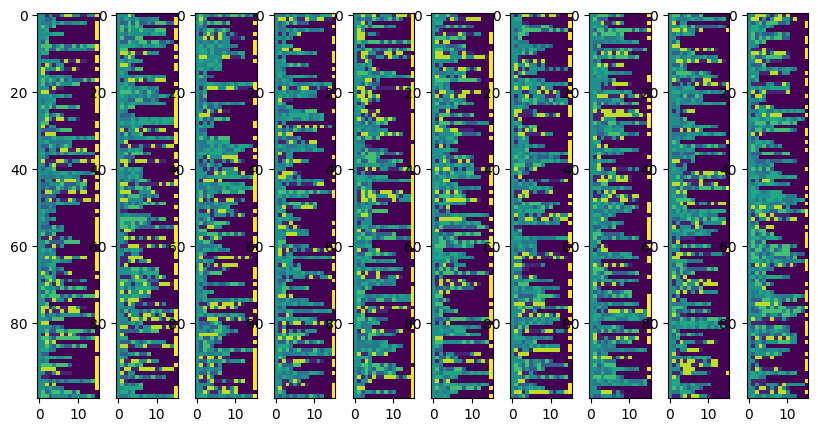

In [14]:
fig, axes = plt.subplots(1, 10, figsize=(10, 5))
for i in range(10):
    ax = axes[i]
    ax.imshow(data[0][i, :100, :].numpy())
    print(data[1][i,:].numpy())

## change process seqC and save to disk

In [69]:
seqC_process = 'norm'
set_idx = 0
summary_type = 0
theta_idx = 0

dataset_path = '../../data/dataset/dataset_L0_exp_set_0.h5'
# process and write the dataset
f = h5py.File(dataset_path, 'r+')

print(f['set_0'].keys())

if seqC_process == 'norm':
    seqC = f[f'set_{set_idx}']['seqC_normed'][:]
elif seqC_process == 'summary':
    if summary_type == 0:
        seqC = f[f'set_{set_idx}']['seqC_summary_0'][:]
    elif summary_type == 1:
        seqC = f[f'set_{set_idx}']['seqC_summary_1'][:]
else:
    raise ValueError(f"seqC_process {seqC_process} not supported")

theta = f[f'set_{set_idx}']['theta'][theta_idx,:]
probR = f[f'set_{set_idx}']['probR'][:, theta_idx][:, np.newaxis]

seqC = torch.from_numpy(seqC)
theta = torch.from_numpy(theta)
probR = torch.from_numpy(probR)
print(seqC.shape, theta.shape, probR.shape)

f.close()

<KeysViewHDF5 ['probR', 'seqC', 'seqC_normed', 'seqC_summary_0', 'seqC_summary_1', 'theta']>
torch.Size([14700, 15]) torch.Size([4]) torch.Size([14700, 1])


## compare speed between numpy and torch, in dataloader

result:

|task|time_numpy|time_torch|
|---|---|---|
|probR repeat|1.2|1.7|
|seqC repeat|26|23|
|probR-choice|83|30|
|[x_seqC, x_choice]|47|19|
|theta repeat|0.63|1.74|
|shuffle along 2nd axis|269|79|
|total|427|145|

In [4]:
C = 100

In [9]:
probR_ = probR
probR_ = probR_.numpy()
print(probR_.shape)
start_time = time.time()
probR_np   = np.repeat(probR_[np.newaxis, :], C, axis=0) # (C, D*M*S, 1)
print('numpy:', (time.time() - start_time)*1000, 'ms')
print(probR_np.shape)

(14700, 1)
numpy: 6.108283996582031 ms
(100, 14700, 1)


In [72]:
# %%timeit
probR_origin = deepcopy(probR)
start_time = time.time()
probR      = probR.unsqueeze_(dim=0).repeat_interleave(C, dim=0) # (C, D*M*S, 1)
print('pytorch:',(time.time() - start_time)*1000, 'ms')
print(probR.shape)
probR = probR_origin

pytorch: 1.1816024780273438 ms
torch.Size([100, 14700, 1])


In [73]:
print()
start_time = time.time()
probR = probR.repeat(C, 1, 1)
print('new pytorch:',(time.time() - start_time)*1000, 'ms')
print(probR.shape)


new pytorch: 2.599954605102539 ms
torch.Size([100, 14700, 1])


In [74]:
seqC_     = seqC.numpy()
print(seqC_.shape)
start_time = time.time()
x_seqC    = np.repeat(seqC_[np.newaxis, :, :], C, axis=0) # (C, D*M*S, 15)
print('numpy:', (time.time() - start_time)*1000, 'ms')
print(x_seqC.shape)

(14700, 15)
numpy: 25.178194046020508 ms
(100, 14700, 15)


In [75]:
print()
print(seqC.shape)
start_time = time.time()
x_seqC    = seqC.unsqueeze_(dim=0).repeat_interleave(C, dim=0) # (C, D*M*S, 15)
print('pytorch:',(time.time() - start_time)*1000, 'ms')
print(x_seqC.shape)


torch.Size([14700, 15])
pytorch: 24.032115936279297 ms
torch.Size([100, 14700, 15])


In [76]:
print(probR.shape)
probR_ = probR.numpy()
start_time = time.time()
x_choice  = np.random.binomial(1, probR_) # (C, D*M*S, 1)
print('numpy:', (time.time() - start_time)*1000, 'ms')
print(x_choice.shape)

torch.Size([100, 14700, 1])
numpy: 74.1569995880127 ms
(100, 14700, 1)


In [77]:
print()
print(probR.shape)
start_time = time.time()
x_choice  = torch.bernoulli(probR) # (C, D*M*S, 1)
print('torch:', (time.time() - start_time)*1000, 'ms')
print(x_choice.shape)


torch.Size([100, 14700, 1])
torch: 28.63454818725586 ms
torch.Size([100, 14700, 1])


In [78]:
for i in range(15):
    print(sum(x_choice[:,i]), probR[:,i][0])

tensor([64.], dtype=torch.float64) tensor([0.6722], dtype=torch.float64)
tensor([62.], dtype=torch.float64) tensor([0.6763], dtype=torch.float64)
tensor([67.], dtype=torch.float64) tensor([0.6703], dtype=torch.float64)
tensor([69.], dtype=torch.float64) tensor([0.6781], dtype=torch.float64)
tensor([70.], dtype=torch.float64) tensor([0.6724], dtype=torch.float64)
tensor([72.], dtype=torch.float64) tensor([0.6740], dtype=torch.float64)
tensor([65.], dtype=torch.float64) tensor([0.6703], dtype=torch.float64)
tensor([74.], dtype=torch.float64) tensor([0.6744], dtype=torch.float64)
tensor([67.], dtype=torch.float64) tensor([0.6740], dtype=torch.float64)
tensor([64.], dtype=torch.float64) tensor([0.6740], dtype=torch.float64)
tensor([63.], dtype=torch.float64) tensor([0.6763], dtype=torch.float64)
tensor([60.], dtype=torch.float64) tensor([0.6740], dtype=torch.float64)
tensor([64.], dtype=torch.float64) tensor([0.6724], dtype=torch.float64)
tensor([69.], dtype=torch.float64) tensor([0.6703],

In [79]:
x_seqC.shape, x_choice.shape

(torch.Size([100, 14700, 15]), torch.Size([100, 14700, 1]))

In [80]:
start_time = time.time()
x         = np.concatenate([x_seqC, x_choice], axis=-1)
print('numpy', end=' ')
print((time.time() - start_time)*1000)
print(x.shape)

numpy 43.585777282714844
(100, 14700, 16)


In [81]:
print()
start_time = time.time()
x         = torch.cat([x_seqC, x_choice], dim=-1)
print('torch', end=' ')
print((time.time() - start_time)*1000)
print(x.shape)


torch 44.75593566894531
torch.Size([100, 14700, 16])


In [82]:
print()
start_time = time.time()
theta_repeat = np.repeat(theta[np.newaxis, :], C, axis=0) # (C, 4)
print('numpy', end=' ')
print((time.time() - start_time)*1000)


numpy 4.783868789672852


In [83]:
start_time = time.time()
theta = theta.unsqueeze_(dim=0).repeat_interleave(C, dim=0) # (C, 4)
print('torch', end=' ')
print((time.time() - start_time)*1000)

torch 0.5629062652587891


In [104]:
# Shuffle x along the 2nd axis
start_time = time.time()
x_batch = np.stack([x[i][np.random.permutation(x.shape[1])] for i in range(x.shape[0])])
print('numpy', end=' ')
print((time.time() - start_time)*1000)

numpy 110.42022705078125


In [107]:
# Shuffle x along the 2nd axis
start_time = time.time()
# x.apply_(lambda y: y.random_(0, x.shape[1]), dim=1)
rand_indices = torch.stack([torch.randperm(x.shape[1]) for _ in range(x.shape[0])])
x.scatter_(1, rand_indices.unsqueeze(-1).expand_as(x), x.gather(1, rand_indices.unsqueeze(-1).expand_as(x)))
print('torch', end=' ')
print((time.time() - start_time)*1000)

torch 59.11993980407715


In [108]:
# Shuffle x along the 2nd axis
start_time = time.time()
x = torch.stack([x[i][torch.randperm(x.shape[1])] for i in range(x.shape[0])])
print('torch', end=' ')
print((time.time() - start_time)*1000)

torch 88.34052085876465


## preprocess seqC and store into the disk

In [56]:
%%timeit
dataset_path = '../../data/dataset/dataset_L0_exp_set_0.h5'
# process and write the dataset
with h5py.File(dataset_path, 'r+') as f:
        
    seqC = f['set_2']['seqC']

    seqC_normed = process_x_seqC_part(
        seqC                = seqC, 
        seqC_process        = 'norm',
        nan2num             = -1,
        summary_type        = 0,
    )
    the_shape = seqC_normed.shape
    seqC_normed = seqC_normed.reshape(the_shape[0]*the_shape[1]*the_shape[2], the_shape[3])
        

1.67 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
dataset_path = '../../data/dataset/dataset_L0_exp_set_0.h5'
# process and write the dataset
with h5py.File(dataset_path, 'r+') as f:

    set_list = list(f.keys())
    print("preprocessing the seqC ...")
    
    for one_set in tqdm(set_list):
            
        seqC = f[one_set]['seqC']

        seqC_normed = process_x_seqC_part(
            seqC                = seqC, 
            seqC_process        = 'norm',
            nan2num             = -1,
            summary_type        = 0,
        )
        the_shape = seqC_normed.shape
        seqC_normed = seqC_normed.reshape(the_shape[0]*the_shape[1]*the_shape[2], the_shape[3])
        
        seqC_summary_0 = process_x_seqC_part(
            seqC                = seqC, 
            seqC_process        = 'summary',
            nan2num             = -1,
            summary_type        = 0,
        )
        
        the_shape = seqC_summary_0.shape
        seqC_summary_0 = seqC_summary_0.reshape(the_shape[0]*the_shape[1]*the_shape[2], the_shape[3])

        seqC_summary_1 = process_x_seqC_part(
            seqC                = seqC, 
            seqC_process        = 'summary',
            nan2num             = -1,
            summary_type        = 1,
        )

        the_shape = seqC_summary_1.shape
        seqC_summary_1 = seqC_summary_1.reshape(the_shape[0]*the_shape[1]*the_shape[2], the_shape[3])

        if 'seqC_normed' in f[one_set].keys(): #update the dataset
            f[one_set].pop('seqC_normed')
            f[one_set].pop('seqC_summary_0')
            f[one_set].pop('seqC_summary_1')
        
        f[one_set].create_dataset('seqC_normed', data=seqC_normed)    
        f[one_set].create_dataset('seqC_summary_0', data=seqC_summary_0)
        f[one_set].create_dataset('seqC_summary_1', data=seqC_summary_1)

In [6]:
# # remove the dataset of seqC_normed in the h5 file
# f = h5py.File(dataset_path, 'r')
# set_list = list(f.keys())
# one_set = set_list[0]
# del f[one_set]['seqC_normed']

f.close()

(50, 15) (50, 15) (50, 11) (50, 8)


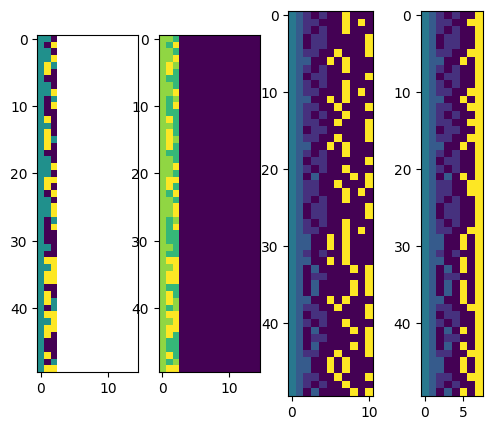

In [20]:
f = h5py.File(dataset_path, 'r')
f['set_0'].keys()
seqC_demo = f['set_0']['seqC'][0, 0, :50, :]
seqC_normed_demo = f['set_0']['seqC_normed'][:50, :]
seqC_summary_0_demo = f['set_0']['seqC_summary_0'][:50, :]
seqC_summary_1_demo = f['set_0']['seqC_summary_1'][:50, :]

print(seqC_demo.shape, seqC_normed_demo.shape, seqC_summary_0_demo.shape, seqC_summary_1_demo.shape)
fig, axes = plt.subplots(1, 4, figsize=(6, 5))
axes[0].imshow(seqC_demo)
axes[1].imshow(seqC_normed_demo)
axes[2].imshow(seqC_summary_0_demo)
axes[3].imshow(seqC_summary_1_demo)
f.close()

## check dataset

In [2]:
dataset_path = '../../data/dataset/dataset_L0_exp_set_0_test.h5'
f = h5py.File(dataset_path, 'r')
f.keys()

<KeysViewHDF5 ['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18']>

In [20]:
seqC_demo = f['set_0']['seqC_normed'][:]
seqC_demo[:2100, :][-1,:]

array([0.5, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

In [81]:
D, M, S = f['set_0']['seqC'].shape[:-1]
D, M, S

(7, 3, 700)

In [46]:
starting_idxs, ending_idxs

(array([    0.,  2100.,  4200.,  8400., 10500., 12600.]),
 array([ 2100.,  4200.,  6300., 10500., 12600., 14700.]))

[6300 6301 6302 ... 8397 8398 8399]
